In [ ]:
import os
import random
import shutil
from pathlib import Path

import tensorflow as tf
from keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
TARGET_DIR = Path(r"C:\Users\hiero\OneDrive\Documents\WIDS 5.0\plantvillage dataset\color_split")

train_ds = tf.keras.utils.image_dataset_from_directory(
    TARGET_DIR / "train",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TARGET_DIR / "val",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TARGET_DIR / "test",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

train_ds = train_ds.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
    num_parallel_calls=AUTOTUNE
)

val_ds = val_ds.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
    num_parallel_calls=AUTOTUNE
)

test_ds = test_ds.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
    num_parallel_calls=AUTOTUNE
)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 37997 files belonging to 38 classes.
Found 8129 files belonging to 38 classes.
Found 8179 files belonging to 38 classes.


In [4]:
NUM_CLASSES = 38   # from train_ds.class_names

simple_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Classifier
    layers.Flatten(),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [5]:
simple_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = simple_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

test_loss_s, test_acc_s = simple_model.evaluate(test_ds)
print("Test accuracy:", test_acc_s)

Epoch 1/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 504s 383ms/step - accuracy: 0.6170 - loss: 1.4940 - val_accuracy: 0.8128 - val_loss: 0.6079
Epoch 2/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 400s 334ms/step - accuracy: 0.9031 - loss: 0.3176 - val_accuracy: 0.8665 - val_loss: 0.4689
Epoch 3/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 415s 349ms/step - accuracy: 0.9581 - loss: 0.1388 - val_accuracy: 0.8299 - val_loss: 0.6221
Epoch 4/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 410s 345ms/step - accuracy: 0.9787 - loss: 0.0709 - val_accuracy: 0.8525 - val_loss: 0.6515
Epoch 5/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 406s 342ms/step - accuracy: 0.9817 - loss: 0.0578 - val_accuracy: 0.8575 - val_loss: 0.6804
Epoch 6/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 401s 338ms/step - accuracy: 0.9850 - loss: 0.0458 - val_accuracy: 0.8604 - val_loss: 0.7149
Epoch 7/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 396s 333ms/step - accuracy: 0.9904 - loss: 0.0294 - val_accuracy: 0.8366 - val_loss: 0.9463
Epoch 8/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 380s 319ms/step - ac

In [9]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)


base_model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model_tl = models.Model(inputs, outputs)

model_tl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_tl = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

test_loss, test_acc = model_tl.evaluate(test_ds)
print("Test accuracy:", test_acc)

Epoch 1/5
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 520s 425ms/step - accuracy: 0.0985 - loss: 3.3820 - val_accuracy: 0.0988 - val_loss: 3.3506
Epoch 2/5
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 536s 451ms/step - accuracy: 0.0959 - loss: 3.3578 - val_accuracy: 0.1016 - val_loss: 3.3628
Epoch 3/5
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 997s 840ms/step - accuracy: 0.0977 - loss: 3.3525 - val_accuracy: 0.0988 - val_loss: 3.3478
Epoch 4/5
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 543s 457ms/step - accuracy: 0.1000 - loss: 3.3475 - val_accuracy: 0.1016 - val_loss: 3.3444
Epoch 5/5
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 494s 416ms/step - accuracy: 0.1023 - loss: 3.3486 - val_accuracy: 0.0988 - val_loss: 3.3451
256/256 ━━━━━━━━━━━━━━━━━━━━ 85s 331ms/step - accuracy: 0.0095 - loss: 3.6439
Test accuracy: 0.09842278808355331


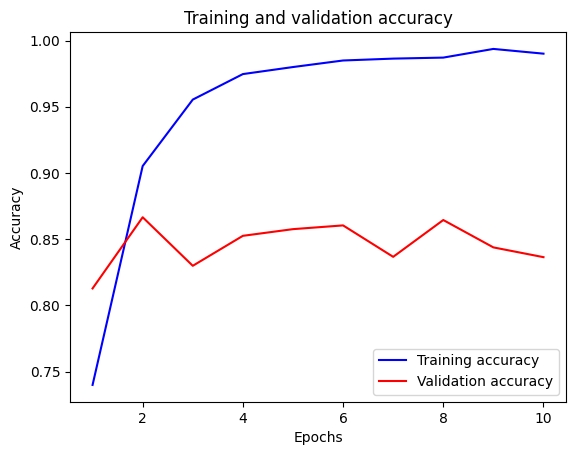

In [10]:
epochs=range(1,11)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, train_acc, 'b', label='Training accuracy') 
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
epochs=range(1,6)
train_acc = history_tl.history['accuracy']
val_acc = history_tl.history['val_accuracy']

plt.plot(epochs, train_acc, 'b', label='Training accuracy') 
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = []
y_pred = []
for images, labels in test_ds:
    predictions = model_tl.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

print("Transfer Learning Model Evaluation:------------------------------------")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_ds.class_names))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

In [8]:
print("Simple CNN Model Evaluation:------------------------------------------")
y_true = []
y_pred = []
for images, labels in test_ds:
    predictions = simple_model.predict(images,verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Simple CNN Model Evaluation:------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.44      0.59        95
           1       0.79      0.76      0.77        94
           2       1.00      0.31      0.47        42
           3       0.81      0.73      0.77       248
           4       0.75      0.95      0.84       226
           5       0.89      0.85      0.87       159
           6       0.74      0.91      0.82       129
           7       0.71      0.50      0.59        78
           8       0.96      1.00      0.98       180
           9       0.72      0.83      0.77       149
          10       0.96      0.99      0.97       175
          11       0.77      0.84      0.81       177
          12       0.92      0.85      0.88       208
          13       0.97      0.90      0.93       162
          14       0.93      0.83      0.88        64
          15       0.97      0.97      0.